In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Read in data
df = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

## Categoricals

In [3]:
# Get Categorical columns
categorical = df.select_dtypes(include='object')

# Instationate LabelEncoder, fit and transform on wind_direction cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df['wind_madrid'])
for col in categorical.filter(regex='wind').columns:
    df[col] = wind_dir_coder.transform(df[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in categorical.filter(regex='condition').columns:
    df[col] = condition_coder.transform(df[col])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61040 entries, 2015-01-01 00:00:00 to 2021-12-30 23:00:00
Data columns (total 64 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           61040 non-null  float64
 1   generation fossil brown coal/lignite         61040 non-null  float64
 2   generation fossil gas                        61040 non-null  float64
 3   generation fossil hard coal                  61040 non-null  float64
 4   generation fossil oil                        61040 non-null  float64
 5   generation hydro pumped storage consumption  61040 non-null  float64
 6   generation hydro run-of-river and poundage   61040 non-null  float64
 7   generation hydro water reservoir             61040 non-null  float64
 8   generation nuclear                           61040 non-null  float64
 9   generation other                     

## Split Data

In [100]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price tomorrow']), df['price tomorrow'], test_size=.3,
                                                    random_state=17)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=17)

## Model

In [101]:
xgb_0 = XGBRegressor(random_state=17)
xgb_0.fit(X_train, y_train)
train_preds_0 = xgb_0.predict(X_train)
val_preds_0 = xgb_0.predict(X_val)


In [102]:
print('r-squared train:', xgb_0.score(X_train,y_train))
print('r-squared val:', xgb_0.score(X_val,y_val))

r-squared train: 0.9871055598257437
r-squared val: 0.9570112146169001


In [105]:
X_val.sort_index(inplace=True)
y_val.sort_index(inplace=True)
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)

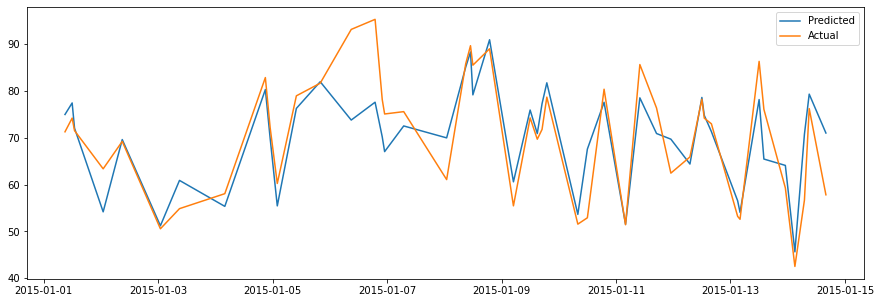

In [107]:
fig = plt.figure(figsize=(15,5))
plt.plot(X_val.index[:48], xgb_0.predict(X_val)[:48], label='Predicted');
plt.plot(y_val.index[:48], y_val.values[:48], label='Actual');
plt.legend();

## Predict Each Year with XGBoost

In [36]:
# Read in data
df = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

# Get Categorical columns
categorical = df.select_dtypes(include='object')

# Instationate LabelEncoder, fit and transform on wind_direction cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df['wind_madrid'])
for col in categorical.filter(regex='wind').columns:
    df[col] = wind_dir_coder.transform(df[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in categorical.filter(regex='condition').columns:
    df[col] = condition_coder.transform(df[col])

In [40]:
# Split data and target
X_train = df.loc['2016':'2021'].drop(columns=['price day ahead', 'price tomorrow'])
X_test  = df.loc['2015'].drop(columns=['price day ahead', 'price tomorrow'])

y_train = df.loc['2016':'2021','price tomorrow']
y_test = df.loc['2015','price tomorrow']

xgb_1 = XGBRegressor(random_state=17)
xgb_1.fit(X_train, y_train)

print('r-squared train:', xgb_1.score(X_train,y_train))
print('r-squared val:', xgb_1.score(X_test,y_test))

r-squared train: 0.9871764936917945
r-squared val: 0.31416156107761106


In [41]:
# Split data and target
X_train = df.loc['2016':'2021'].drop(columns=[ 'price tomorrow'])
X_test  = df.loc['2015'].drop(columns=['price tomorrow'])

y_train = df.loc['2016':'2021','price tomorrow']
y_test = df.loc['2015','price tomorrow']

xgb_1_1 = XGBRegressor(random_state=17)
xgb_1_1.fit(X_train, y_train)

print('r-squared train:', xgb_1_1.score(X_train,y_train))
print('r-squared val:', xgb_1_1.score(X_test,y_test))

r-squared train: 0.9880251508431831
r-squared val: 0.270363940082441


## 2016

In [42]:
# Split data and target
X_train = df.loc['2015' and '2017':].drop(columns=['price day ahead', 'price tomorrow'])
X_test  = df.loc['2016'].drop(columns=['price day ahead', 'price tomorrow'])

y_train = df.loc['2015' and '2017':,'price tomorrow']
y_test = df.loc['2016', 'price tomorrow']

xgb_2 = XGBRegressor(random_state=17)
xgb_2.fit(X_train, y_train)

print('r-squared train:', xgb_2.score(X_train,y_train))
print('r-squared val:', xgb_2.score(X_test,y_test))

r-squared train: 0.9901466938980316
r-squared val: 0.5064626151911646


In [44]:
# Split data and target
X_train = df.loc['2015' and '2017':].drop(columns=['price tomorrow'])
X_test  = df.loc['2016'].drop(columns=['price tomorrow'])

y_train = df.loc['2015' and '2017':,'price tomorrow']
y_test = df.loc['2016', 'price tomorrow']

xgb_2 = XGBRegressor(random_state=17)
xgb_2.fit(X_train, y_train)

print('r-squared train:', xgb_2.score(X_train,y_train))
print('r-squared val:', xgb_2.score(X_test,y_test))

r-squared train: 0.9895693397184889
r-squared val: 0.5308095353672708


## 2020 

In [113]:
# Split data and target
X_train = df.loc[:'2016'].drop(columns=['price day ahead','price tomorrow'])
X_test  = df.loc['2021'].drop(columns=['price day ahead','price tomorrow'])

y_train = df.loc[:'2016','price tomorrow']
y_test = df.loc['2021', 'price tomorrow']

xgb_20 = XGBRegressor(random_state=17)
xgb_20.fit(X_train, y_train)

print('r-squared train:', xgb_20.score(X_train,y_train))
print('r-squared val:', xgb_20.score(X_test,y_test))

r-squared train: 0.9653590952852152
r-squared val: -0.42797343776715935


In [112]:
# Split data and target
X_train = df.loc[:'2019'].drop(columns=['price day ahead','price tomorrow'])
X_test  = df.loc['2020'].drop(columns=['price day ahead','price tomorrow'])

y_train = df.loc[:'2019','price tomorrow']
y_test = df.loc['2020', 'price tomorrow']

xgb_20 = XGBRegressor(random_state=17)
xgb_20.fit(X_train, y_train)

print('r-squared train:', xgb_20.score(X_train,y_train))
print('r-squared val:', xgb_20.score(X_test,y_test))

r-squared train: 0.9207154169566831
r-squared val: 0.23056651326048394


In [111]:
# Split data and target
X_train = df.loc[:'2019'].drop(columns=['price tomorrow'])
X_test  = df.loc['2020'].drop(columns=['price tomorrow'])

y_train = df.loc[:'2019','price tomorrow']
y_test = df.loc['2020', 'price tomorrow']

xgb_20_1 = XGBRegressor(random_state=17)
xgb_20_1.fit(X_train, y_train)

print('r-squared train:', xgb_20_1.score(X_train,y_train))
print('r-squared val:', xgb_20_1.score(X_test,y_test))

r-squared train: 0.9225919042127004
r-squared val: 0.2861230524770665


## 2021

In [45]:
# Split data and target
X_train = df.loc[:'2019' and '2021'].drop(columns=['price day ahead', 'price tomorrow'])
X_test  = df.loc['2020'].drop(columns=['price day ahead', 'price tomorrow'])

y_train = df.loc[:'2019' and '2021','price tomorrow']
y_test = df.loc['2020', 'price tomorrow']

xgb_21 = XGBRegressor(random_state=17)
xgb_21.fit(X_train, y_train)

print('r-squared train:', xgb_21.score(X_train,y_train))
print('r-squared val:', xgb_21.score(X_test,y_test))

r-squared train: 0.9855425557787146
r-squared val: 0.7927274056517825


In [46]:
# Split data and target
X_train = df.loc[:'2019' and '2021'].drop(columns=['price tomorrow'])
X_test  = df.loc['2020'].drop(columns=['price tomorrow'])

y_train = df.loc[:'2019' and '2021','price tomorrow']
y_test = df.loc['2020', 'price tomorrow']

xgb_21_1 = XGBRegressor(random_state=17)
xgb_21_1.fit(X_train, y_train)

print('r-squared train:', xgb_21_1.score(X_train,y_train))
print('r-squared val:', xgb_21_1.score(X_test,y_test))

r-squared train: 0.9855461717319575
r-squared val: 0.7945500622143079


In [48]:
import matplotlib.pyplot as plt

In [93]:
X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)

C:\Users\holde\anaconda3\lib\site-packages\pandas\core\series.py:3424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().sort_index(


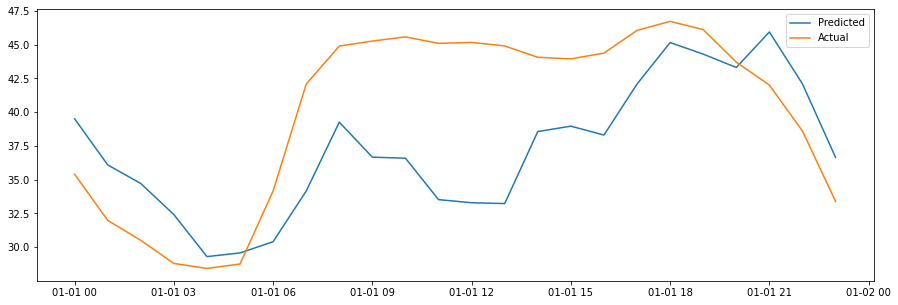

In [73]:
fig = plt.figure(figsize=(15,5))
plt.plot(X_test.index[:24], xgb_21_1.predict(X_test)[:24], label='Predicted');
plt.plot(y_test.index[:24], y_test.values[:24], label='Actual');
plt.legend();

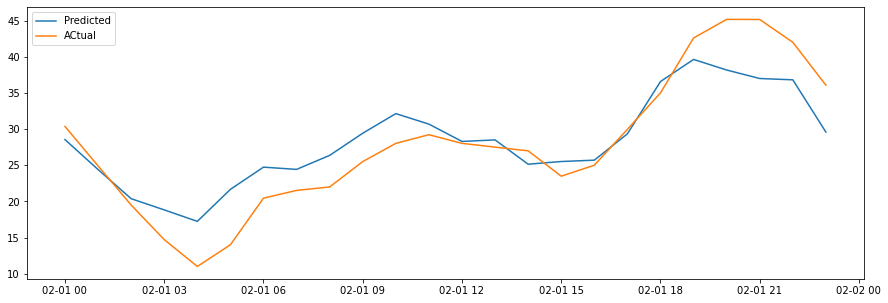

In [74]:
fig = plt.figure(figsize=(15,5))
plt.plot(X_test.index[24:48], xgb_21_1.predict(X_test)[24:48], label='Predicted');
plt.plot(y_test.index[24:48], y_test.values[24:48], label='ACtual');
plt.legend();

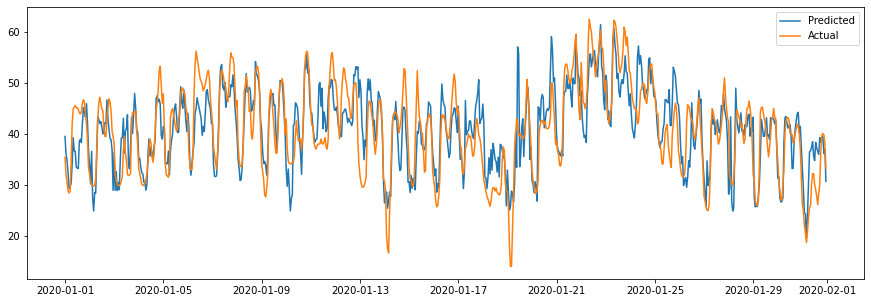

In [99]:
fig = plt.figure(figsize=(15,5))
plt.plot(X_test.index[:744], xgb_21_1.predict(X_test)[:744], label='Predicted');
plt.plot(y_test.index[:744], y_test.values[:744], label='Actual');
plt.legend();

In [81]:
y_test.

2020-01-01 00:00:00    35.40
2020-01-01 01:00:00    31.98
2020-01-01 02:00:00    30.50
2020-01-01 03:00:00    28.79
2020-01-01 04:00:00    28.42
2020-01-01 05:00:00    28.75
2020-01-01 06:00:00    34.16
2020-01-01 07:00:00    42.07
2020-01-01 08:00:00    44.89
2020-01-01 09:00:00    45.26
2020-01-01 10:00:00    45.57
2020-01-01 11:00:00    45.09
2020-01-01 12:00:00    45.16
2020-01-01 13:00:00    44.90
2020-01-01 14:00:00    44.06
2020-01-01 15:00:00    43.94
2020-01-01 16:00:00    44.37
2020-01-01 17:00:00    46.05
2020-01-01 18:00:00    46.72
2020-01-01 19:00:00    46.11
2020-01-01 20:00:00    43.70
2020-01-01 21:00:00    42.00
2020-01-01 22:00:00    38.60
2020-01-01 23:00:00    33.39
2020-02-01 00:00:00    30.37
2020-02-01 01:00:00    24.91
2020-02-01 02:00:00    19.50
2020-02-01 03:00:00    14.71
2020-02-01 04:00:00    11.00
2020-02-01 05:00:00    14.00
2020-02-01 06:00:00    20.45
2020-02-01 07:00:00    21.52
2020-02-01 08:00:00    22.00
2020-02-01 09:00:00    25.51
2020-02-01 10:

In [78]:
y_test.groupby(by = [y_test.index.month, y_test.index.day,]).count()

1   1     24
    2     24
    3     24
    4     24
    5     24
          ..
12  27    24
    28    24
    29    24
    30    24
    31    24
Name: price tomorrow, Length: 366, dtype: int64

In [79]:
len(y_test)

8784

In [114]:
df.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'generation total', 'diff', 'generation_scheduled',
       'consumption_scheduled', 'transmission_ps', 'transmission_sp',
       'transmission_fs', 'transmission_sf', 'temp_madrid', 'dew_point_madrid',
       'humidities_madrid', 'wind_madrid', 'wind_speeds_madrid',
       'pressures_madrid', 'condition_madrid', 'temp_seville',
       'dew_point_seville', 'humidities_seville

In [155]:
def to_list(x):
    return [i for i in x]
        

In [161]:
df.groupby(by=[df.index.year, df.index.month, df.index.day]).apply(list)

2015  1   1     [generation biomass, generation fossil brown c...
          2     [generation biomass, generation fossil brown c...
          3     [generation biomass, generation fossil brown c...
          4     [generation biomass, generation fossil brown c...
          5     [generation biomass, generation fossil brown c...
                                      ...                        
2021  12  26    [generation biomass, generation fossil brown c...
          27    [generation biomass, generation fossil brown c...
          28    [generation biomass, generation fossil brown c...
          29    [generation biomass, generation fossil brown c...
          30    [generation biomass, generation fossil brown c...
Length: 2544, dtype: object

In [181]:
range_ = pd.date_range(dt.datetime(2015,1,1), dt.datetime(2021,12,31), freq='D')[:10]
range_  = [str(x)[:10] for x in range_]
df_2 = pd.DataFrame(columns = df.columns)
for day in range_:
    try:
        df_2 = pd.concat([df_2, df.loc[day]], axis=0)
    except KeyError:
        continue

In [191]:
df.loc[range_[0]]['generation biomass'].values

array([447., 449., 448., 438., 428., 410., 401., 408., 413., 419., 422.,
       421., 428., 425., 423., 421., 422., 426., 427., 442., 445., 443.,
       440., 438.])

In [180]:
[str(x)[:10] for x in range_]

['2015-01-01',
 '2015-01-02',
 '2015-01-03',
 '2015-01-04',
 '2015-01-05',
 '2015-01-06',
 '2015-01-07',
 '2015-01-08',
 '2015-01-09',
 '2015-01-10']